In [146]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import shap

### Read the CSV

In [147]:
test = pd.read_csv("../model_dev/densenet_data/densenet_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
train = pd.read_csv("../model_dev/densenet_data/densenet_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
valid = pd.read_csv("../model_dev/densenet_data/densenet_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

print(test.columns)
test.head()

Index(['path_to_image', 'path_to_dcm', 'age', 'sex', 'race', 'insurance_type',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'embeddings'],
      dtype='object')


,path_to_image,path_to_dcm,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,embeddings
0,train/patient47347/study3/view1_frontal.jpg,train/patient47347/study3/view1_frontal.dcm,78.0,1,0,1,0,0,1,0,...,1,0,0,1,0,1,0,1,1,"[0.0029132624622434378, 0.1020001769065857, 0...."
1,train/patient37527/study12/view1_frontal.jpg,train/patient37527/study12/view1_frontal.dcm,63.0,0,1,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[0.0014348188415169716, 0.0543656125664711, 0...."
2,train/patient41208/study9/view1_frontal.jpg,train/patient41208/study9/view1_frontal.dcm,70.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0.001982336398214102, 0.040021587163209915, 0..."
3,train/patient39357/study1/view1_frontal.jpg,train/patient39357/study1/view1_frontal.dcm,79.0,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"[0.001741771469824016, 0.0560498870909214, 0.1..."
4,train/patient31982/study4/view1_frontal.jpg,train/patient31982/study4/view1_frontal.dcm,67.0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,"[9.678312198957428e-05, 0.12247737497091293, 0..."


### Convert embeddings from str to list (a bit long for large data sets)

In [148]:
test['embeddings'] = test['embeddings'].apply(ast.literal_eval)

In [149]:
train['embeddings'] = train['embeddings'].apply(ast.literal_eval)

### Remove columns

In [150]:
test = test.drop(columns=['path_to_image', 'path_to_dcm'])
train = train.drop(columns=['path_to_image', 'path_to_dcm'])


### Remove rows that were not processed (embeddings = 0)

In [151]:
initial_size = test.shape[0] 

# The previous logic with transforming the list to string and filtering on the length of said string is not necessarily stable and misleading.
# Let's implement a more explicit test for what we actually care about: 

test = test[test['embeddings'].apply(type) == list]

final_size = test.shape[0] 

print(f'Number of test removed rows = {initial_size - final_size}')

initial_size = train.shape[0] 

train = train[train['embeddings'].apply(type) == list]

final_size = train.shape[0] 

print(f'Number of train removed rows = {initial_size - final_size}')

Number of test removed rows = 51
Number of train removed rows = 67


### Convert age to binary to study bias

In [152]:
a = 70
test['age'] = (test['age'] >= a).astype(int)
valid['age'] = (valid['age'] >= a).astype(int)
train['age'] = (train['age'] >= a).astype(int)

### Train test

In [153]:
train_embeddings = pd.DataFrame(train['embeddings'].tolist())
test_embeddings = pd.DataFrame(test['embeddings'].tolist())
valid_embeddings = pd.DataFrame(valid['embeddings'].tolist())


# Diseases to predict
# diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
#             'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
# diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pleural Effusion']

cath = ['age', 'sex', 'race', 'insurance_type']

# Labels for train and test
y_train = train[diseases]
y_test = test[diseases]

# Create x_train and x_test
x_train = pd.concat([train.reset_index(), train_embeddings], axis=1)
x_test =  pd.concat([test.reset_index(), test_embeddings], axis=1)

x_train.drop(columns=["embeddings"] + diseases, inplace=True)
x_test.drop(columns=["embeddings"] + diseases, inplace=True)



# Labels for train and test
y_train = train[diseases]
y_test = test[diseases]
y_valid = valid[diseases]
y_no_finding = test["No Finding"]
y_sex = test['sex']
y_race = test['race']
y_insurance = test['insurance_type']
y_age = test['age']

train_cath = train[cath]
test_cath = test[cath]


### PCA to reduce embeddings

In [154]:
# Step 1: Standardize the embeddings_list to have mean 0 and variance 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.stack(train_embeddings.values))
X_test_scaled = scaler.transform(np.stack(test_embeddings.values))

# Step 2: Set target variance threshold (e.g., 95%)
variance_threshold = 0.95

# Step 3: Fit PCA to determine the optimal number of components based on variance threshold
pca_full = PCA()
pca_full.fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Step 4: Find the number of components that meets the variance threshold
optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1
print(f"Optimal number of components to retain {variance_threshold*100}% variance: {optimal_components}")

#95% variance means that the selected principal components (reduced dimensions) retain 95% of the total variability present in the original high-dimensional data.

Optimal number of components to retain 95.0% variance: 305


In [155]:
# Apply PCA if wanted
pca = PCA(n_components=optimal_components)
x_train_subset = pca.fit_transform(X_train_scaled)
x_test_subset = pca.transform(X_test_scaled)


In [156]:
train_cath = pd.get_dummies(train_cath, columns= ['age', 'sex', 'race', 'insurance_type'])
test_cath = pd.get_dummies(test_cath, columns= ['age', 'sex', 'race', 'insurance_type'])
train_cath = train_cath.astype('int')
test_cath = test_cath.astype('int')

In [158]:
x_train_subset = pd.DataFrame(x_train_subset) 
x_train_subset = x_train_subset.reset_index(drop=True)

x_test_subset = pd.DataFrame(x_test_subset)
x_test_subset = x_test_subset.reset_index(drop=True)

train_cath = train_cath.reset_index(drop=True)
test_cath = test_cath.reset_index(drop=True)

In [159]:
columns_to_remove = ['age_1', 'sex_1', 'race_2', 'insurance_type_2']

# Drop these columns from the DataFrame
train_cath = train_cath.drop(columns=columns_to_remove)
test_cath = test_cath.drop(columns=columns_to_remove)

### Add the cathegories in the training and testing set

In [160]:
x_train_subset = pd.concat([train_cath, x_train_subset], axis=1)
x_test_subset = pd.concat([test_cath, x_test_subset], axis=1)

In [164]:
x_train_subset

,age_0,sex_0,race_0,race_1,insurance_type_0,insurance_type_1,0,1,2,3,...,295,296,297,298,299,300,301,302,303,304
0,1,1,1,0,0,1,13.176661,2.432126,-0.457243,-7.769527,...,-0.070751,0.002563,0.286103,0.135025,0.800595,-0.373900,-0.249542,0.392147,-0.537553,-1.089433
1,1,1,0,1,0,0,-9.891466,0.859173,0.341570,5.364088,...,0.230183,0.068595,0.071214,-0.360602,-0.472565,-0.310042,-0.930637,0.184726,0.018270,0.595597
2,0,1,1,0,0,1,-18.705509,9.468058,-10.037300,-4.222531,...,0.220116,-0.571987,-1.226252,-0.098359,-0.630293,0.100303,-0.454085,-0.643174,-0.045753,-0.311553
3,1,0,1,0,0,0,19.590418,-3.840863,-2.906075,-6.210735,...,0.093338,-0.708476,0.731337,-0.149251,0.195635,-0.640373,0.426457,0.544058,-0.382106,0.120094
4,1,0,1,0,0,1,5.558868,-12.874069,9.275970,-3.755498,...,0.207104,1.355468,-0.373814,-0.205091,-0.500612,-0.267641,0.016919,0.494535,0.279519,-0.000539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67191,1,0,1,0,0,1,18.838259,-6.415434,6.753741,-2.032186,...,-0.577534,0.021436,0.150058,-0.142784,0.562231,-0.390544,-0.153853,0.481942,-1.173563,-0.079552
67192,0,1,1,0,0,1,-12.360030,4.537242,-2.088920,7.828038,...,0.177035,-0.593365,0.599736,-0.383169,0.354172,0.355470,-0.242406,1.115377,0.834023,-0.513377
67193,1,1,1,0,0,0,1.024817,19.306928,-2.861782,-8.144903,...,-1.092845,0.570575,-0.663657,0.866927,0.231673,-0.155757,-1.245155,-0.182033,-1.387801,-0.034289
67194,0,1,0,0,0,1,-6.527677,3.299355,4.574663,1.517789,...,0.233591,0.098223,-0.827648,0.358284,0.139071,0.564646,0.352423,0.520252,-0.137115,0.846911


In [165]:
# diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 
#             'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
#             'Pleural Effusion', 'Pleural Other', 'Fracture']
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
# diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pleural Effusion']

### Training with SHAP interpretability (takes a long time)

In [166]:
def train_model(x_train, y_train, x_test, y_test, model):
    multi_output_model = MultiOutputClassifier(model)
    multi_output_model.fit(x_train, y_train)

    # Dictionary to hold the probabilistic predictions, if available
    y_test_preds_proba = {}
    shap_values = {}

    # Check if the model supports probability predictions and compute SHAP values for each output
    if hasattr(model, "predict_proba"):
        for idx, estimator in enumerate(multi_output_model.estimators_):
            disease = diseases[idx]
            probs = estimator.predict_proba(x_test)
            y_test_preds_proba[disease] = probs[:, 1]

            # Create a SHAP explainer and compute SHAP values for each estimator
            explainer = shap.Explainer(estimator, x_train)
            shap_values[disease] = explainer(x_test)
    else:
        y_test_preds_proba = None
        shap_values = None

    return y_test_preds_proba, shap_values, explainer

# Example usage with x_train_subset, y_train, x_test_subset, y_test, and diseases defined
xgb_model = XGBClassifier(
    use_label_encoder=False,      
    eval_metric='logloss',   
    learning_rate=0.1,
    random_state=42
)

y_pred, shap_values, explainer = train_model(
    x_train=x_train_subset, 
    y_train=y_train, 
    x_test=x_test_subset, 
    y_test=y_test, 
    model=xgb_model, 
)


[21:11:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:12:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:12:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:12:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:12:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:12:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

100%|===================| 40116/40307 [02:37<00:00]        

In [167]:
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
x_test_subset

,age_0,sex_0,race_0,race_1,insurance_type_0,insurance_type_1,0,1,2,3,...,295,296,297,298,299,300,301,302,303,304
0,0,0,1,0,0,1,-15.027572,7.189695,3.414470,-1.322660,...,0.045014,-0.917356,-0.739650,-0.253280,0.751165,0.258531,0.662323,0.148656,1.468428,0.210845
1,1,1,0,1,0,0,-4.397246,0.640648,6.159016,0.342972,...,0.144827,0.664998,-0.877850,0.098981,-0.146954,-0.712736,-0.421340,0.503696,-0.341627,0.012615
2,0,1,1,0,0,1,12.895339,-0.673721,-6.978326,-4.127758,...,-0.234154,-0.503943,-0.493272,0.046649,-0.421381,-0.380740,0.564594,0.073451,-0.316430,0.939289
3,0,0,0,1,0,1,4.554292,0.137144,-2.419334,8.033988,...,-0.504906,0.106494,-0.028352,0.983190,0.400899,-0.578402,-0.668943,1.050528,0.220951,0.564990
4,1,1,1,0,1,0,-16.267393,-12.983082,-1.893279,-4.087108,...,-0.205784,0.184892,-0.077661,-0.024764,0.609920,-0.180253,0.148022,0.738545,0.206927,-0.239453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40302,1,0,0,1,0,0,13.448618,-6.065553,0.034937,8.202098,...,-0.053070,0.279351,-0.435547,0.705266,0.340017,-0.127896,-0.324906,-0.735621,-0.626962,-0.165819
40303,0,0,1,0,0,1,-9.873505,-7.919516,-0.985797,10.069651,...,-0.188892,-0.194855,0.721829,0.211574,-0.005732,-0.105689,0.347961,0.148727,-0.007547,0.847688
40304,1,0,1,0,0,0,0.622981,3.898730,6.618232,4.620034,...,0.575787,0.292616,-0.149299,0.225036,0.222053,0.112624,-0.695357,0.346050,-0.586593,-1.432638
40305,1,0,1,0,0,0,15.723229,4.236523,0.656678,-3.687916,...,0.301896,0.155318,-0.693649,-0.445042,-0.181035,0.507104,-0.210407,0.370757,0.103489,0.365502


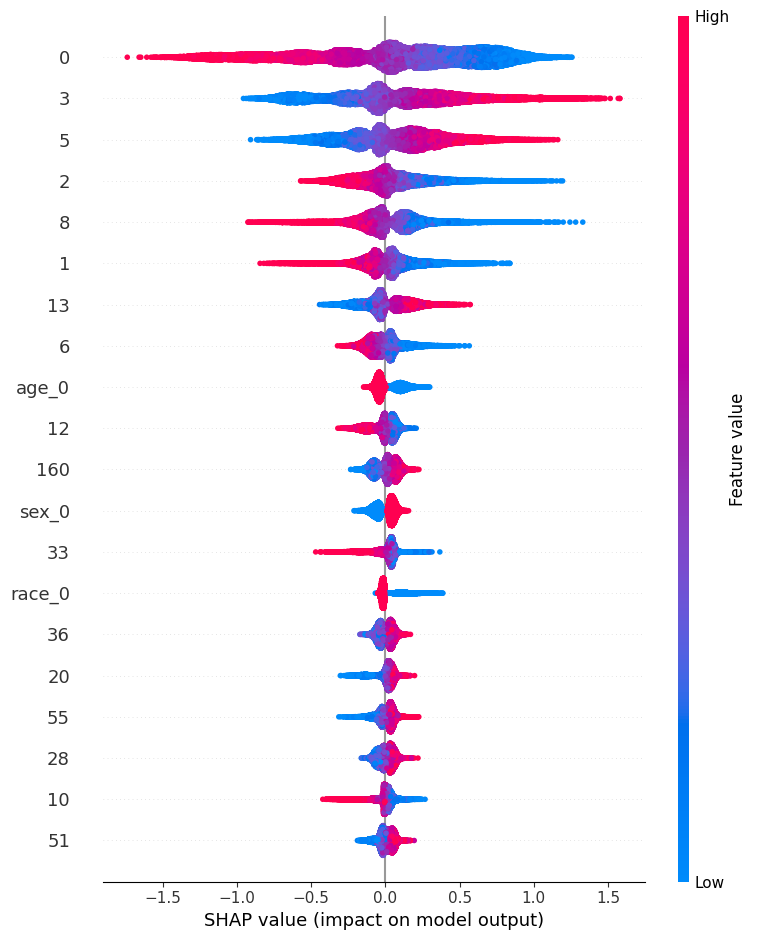

In [217]:
disease_name = 'Cardiomegaly' 
feat_names = list(x_test_subset.columns)

shap.summary_plot(shap_values[disease_name], feature_names=feat_names)




In [169]:
predictions = y_pred.values
targets = y_test.values

In [189]:
predictions = np.transpose(np.stack(list(y_pred.values()), axis=0))
predictions

array([[0.09716679, 0.67433697, 0.44889572, 0.1526783 , 0.11158279,
        0.6353721 ],
       [0.04743156, 0.60970783, 0.27969855, 0.08336623, 0.06802288,
        0.52347034],
       [0.0617379 , 0.293082  , 0.11479796, 0.11764693, 0.08849843,
        0.16484201],
       ...,
       [0.04927084, 0.73976684, 0.15141083, 0.13057278, 0.04897277,
        0.4364196 ],
       [0.03730718, 0.34976116, 0.04764125, 0.15478076, 0.05792987,
        0.08417533],
       [0.01650241, 0.55369514, 0.04072399, 0.1837514 , 0.3288257 ,
        0.3014333 ]], dtype=float32)

In [190]:
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
# diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pleural Effusion']

In [191]:
def compute_metrics(predictions, targets):
    # Calculate metrics for each disease
    metrics = {}
    for idx, disease in enumerate(diseases):
        disease_pred = predictions[disease]
        disease_true = targets[disease]
        # disease_pred = predictions[:, idx]
        # disease_true = targets[:, idx]
        auc_roc = roc_auc_score(disease_true, disease_pred)
        f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
        accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
        tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        tn_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
        fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
        fp_rate = fp / (tn + fp) if (tn + fp) > 0 else 0
        
        # Calculate Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
        auprc = auc(recall, precision)

        metrics[disease] = {
            'Accuracy': accuracy,
            'AUC': auc_roc,
            'AUPRC': auprc,
            'F1 Score': f1,
            'TP Rate': tp_rate,
            'FN Rate': fn_rate,
            'TN Rate': tn_rate,
            'FP Rate': fp_rate
        }
    return metrics

metrics = compute_metrics(pd.DataFrame(y_pred), pd.DataFrame(y_test))
print(metrics)

{'Cardiomegaly': {'Accuracy': 0.881906368620835, 'AUC': 0.8050854255323032, 'AUPRC': 0.3916276920694115, 'F1 Score': 0.18632478632478633, 'TP Rate': 0.10987903225806452, 'FN Rate': 0.8901209677419355, 'TN Rate': 0.9902396242962628, 'FP Rate': 0.009760375703737233}, 'Lung Opacity': {'Accuracy': 0.644280149849902, 'AUC': 0.6913580635007892, 'AUPRC': 0.6402207793829264, 'F1 Score': 0.6688530648066886, 'TP Rate': 0.7296915944366055, 'FN Rate': 0.27030840556339447, 'TN Rate': 0.5614523774617602, 'FP Rate': 0.43854762253823976}, 'Edema': {'Accuracy': 0.7761927208673431, 'AUC': 0.7846780333830263, 'AUPRC': 0.5060610039480122, 'F1 Score': 0.35568887936575955, 'TP Rate': 0.25709860609189467, 'FN Rate': 0.7429013939081053, 'TN Rate': 0.9403696688655215, 'FP Rate': 0.05963033113447848}, 'Atelectasis': {'Accuracy': 0.8462053737564195, 'AUC': 0.6151481627553516, 'AUPRC': 0.20953760727281415, 'F1 Score': 0.0003225286244154168, 'TP Rate': 0.00016129032258064516, 'FN Rate': 0.9998387096774194, 'TN Rat

In [192]:

# Calculate metrics for each disease and for each class

metrics_female = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 1, idx]
    disease_true = targets[y_sex == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_female[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_male = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 0, idx]
    disease_true = targets[y_sex == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_male[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_white = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 0, idx]
    disease_true = targets[y_race == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_white[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_black = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 2, idx]
    disease_true = targets[y_race == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_black[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_asian = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 1, idx]
    disease_true = targets[y_race == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_asian[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    

metrics_medicaid = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 0, idx]
    disease_true = targets[y_insurance == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicaid[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_medicare = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 1, idx]
    disease_true = targets[y_insurance == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicare[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_private = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 2, idx]
    disease_true = targets[y_insurance == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_private[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    

metrics_young = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 0, idx]
    disease_true = targets[y_age == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_young[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_old = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 1, idx]
    disease_true = targets[y_age == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_old[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

In [193]:
# Initialize an empty list to store the data
data_sex = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_male = metrics_male[disease]['AUC'] *100
    auc_female = metrics_female[disease]['AUC'] *100
    tp_rate_male = metrics_male[disease]['TP Rate'] *100
    tp_rate_female = metrics_female[disease]['TP Rate'] *100
    fp_rate_male = metrics_male[disease]['FP Rate'] *100
    fp_rate_female = metrics_female[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc_sex = abs(auc_male - auc_female)
    eq_odds_sex = 0.5 * (abs(tp_rate_male - tp_rate_female) + abs(fp_rate_male - fp_rate_female))
    
    # Append to the data list
    data_sex.append([disease, auprc_overall, auc_overall, auc_male, auc_female, delta_auc_sex, eq_odds_sex])

# Create a DataFrame
df_sex = pd.DataFrame(data_sex, columns=['Disease', 'AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df_sex.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_Male': "{:.3f}", 
    'AUC_Female': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_Male,AUC_Female,Delta AUC,EqOdds
0,Cardiomegaly,39.163,80.509,80.669,80.193,0.476,1.378
1,Lung Opacity,64.022,69.136,69.128,69.161,0.033,0.528
2,Edema,50.606,78.468,78.720,78.142,0.578,2.515
3,Atelectasis,20.954,61.515,62.610,59.719,2.891,0.013
4,Pneumothorax,27.648,74.947,74.063,76.141,2.078,0.431
5,Pleural Effusion,70.473,81.049,80.868,81.303,0.435,0.813


In [194]:
# Initialize an empty list to store the data
data_race = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_white[disease]['AUC'] *100,
        metrics_black[disease]['AUC'] *100,
        metrics_asian[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_white[disease]['TP Rate'] *100,
        metrics_black[disease]['TP Rate'] *100,
        metrics_asian[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_white[disease]['FP Rate'] *100,
        metrics_black[disease]['FP Rate'] *100,
        metrics_asian[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc_race = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_race = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_race.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_race, eq_odds_race])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds']
df_race = pd.DataFrame(data_race, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_race.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_White': "{:.3f}", 
    'AUC_Black': "{:.3f}",
    'AUC_Asian': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_White,AUC_Black,AUC_Asian,Max Delta AUC,Max EqOdds
0,Cardiomegaly,39.163,80.509,80.001,80.432,81.473,1.471,5.071
1,Lung Opacity,64.022,69.136,68.879,70.643,69.645,1.764,3.315
2,Edema,50.606,78.468,78.476,77.233,78.835,1.602,3.224
3,Atelectasis,20.954,61.515,61.586,59.002,61.529,2.584,0.010
4,Pneumothorax,27.648,74.947,74.296,78.058,76.334,3.762,0.902
5,Pleural Effusion,70.473,81.049,80.917,80.279,81.868,1.590,3.132


In [195]:
# Initialize an empty list to store the data
data_age = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_old = metrics_old[disease]['AUC'] *100
    auc_young = metrics_young[disease]['AUC'] *100
    tp_rate_old = metrics_old[disease]['TP Rate'] *100
    tp_rate_young = metrics_young[disease]['TP Rate'] *100
    fp_rate_old = metrics_old[disease]['FP Rate'] *100
    fp_rate_young = metrics_young[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc_age = abs(auc_old - auc_young)
    eq_odds_age = 0.5 * (abs(tp_rate_old - tp_rate_young) + abs(fp_rate_old - fp_rate_young))
    
    # Append to the data list
    data_age.append([disease, auprc_overall, auc_overall, auc_old, auc_young, delta_auc_age, eq_odds_age])

# Create a DataFrame
df_age = pd.DataFrame(data_age, columns=['Disease', 'AUPRC', 'AUC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df_age.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_old': "{:.3f}", 
    'AUC_young': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC', 'AUPRC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_old,AUC_young,Delta AUC,EqOdds
0,Cardiomegaly,39.163,80.509,77.268,81.706,4.438,1.259
1,Lung Opacity,64.022,69.136,65.225,70.955,5.730,9.243
2,Edema,50.606,78.468,76.483,79.283,2.800,4.277
3,Atelectasis,20.954,61.515,58.743,63.053,4.311,0.022
4,Pneumothorax,27.648,74.947,73.796,74.734,0.938,0.845
5,Pleural Effusion,70.473,81.049,80.633,81.210,0.577,5.979


In [196]:
# Initialize an empty list to store the data
data_health = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_medicaid[disease]['AUC'] *100,
        metrics_medicare[disease]['AUC'] *100,
        metrics_private[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_medicaid[disease]['TP Rate'] *100,
        metrics_medicare[disease]['TP Rate'] *100,
        metrics_private[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_medicaid[disease]['FP Rate'] *100,
        metrics_medicare[disease]['FP Rate'] *100,
        metrics_private[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc_health = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_health = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_health.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_health, eq_odds_health])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds']
df_health = pd.DataFrame(data_health, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_health.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_Medicaid': "{:.3f}", 
    'AUC_Medicare': "{:.3f}",
    'AUC_Private': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC',  'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_Medicaid,AUC_Medicare,AUC_Private,Max Delta AUC,Max EqOdds
0,Cardiomegaly,39.163,80.509,81.723,79.578,81.025,2.144,3.512
1,Lung Opacity,64.022,69.136,71.416,67.213,72.076,4.864,7.690
2,Edema,50.606,78.468,77.024,77.469,80.547,3.523,3.297
3,Atelectasis,20.954,61.515,61.429,59.866,65.068,5.202,0.012
4,Pneumothorax,27.648,74.947,74.557,74.440,74.394,0.163,0.579
5,Pleural Effusion,70.473,81.049,81.841,80.482,81.799,1.358,6.144


In [197]:
# Initialize an empty list to store the data
data = []
i=0
# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():

    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100

    # Append to the data list
    data.append([disease, auprc_overall, auc_overall] + [df_sex['Delta AUC'][i], df_sex['EqOdds'][i]] + [df_race['Max Delta AUC'][i], df_race['Max EqOdds'][i]] + [df_age['Delta AUC'][i], df_age['EqOdds'][i]] + [df_health['Max Delta AUC'][i], df_health['Max EqOdds'][i]])
    i+=1
# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'Delta AUC sex', 'EqOdds sex', 'Delta AUC race', 'EqOdds race', 'Delta AUC age', 'EqOdds age', 'Delta AUC health', 'EqOdds health']
df = pd.DataFrame(data, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'Delta AUC sex': "{:.3f}", 
    'EqOdds sex': "{:.3f}",
    'Delta AUC race': "{:.3f}", 
    'EqOdds race': "{:.3f}",
    'Delta AUC age': "{:.3f}", 
    'EqOdds age': "{:.3f}",
    'Delta AUC health': "{:.3f}", 
    'EqOdds health': "{:.3f}"
}).background_gradient(cmap='Reds', subset=['AUC',  'AUPRC', 'Delta AUC sex', 'EqOdds sex', 'Delta AUC race', 'EqOdds race', 'Delta AUC age', 'EqOdds age', 'Delta AUC health', 'EqOdds health'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,Delta AUC sex,EqOdds sex,Delta AUC race,EqOdds race,Delta AUC age,EqOdds age,Delta AUC health,EqOdds health
0,Cardiomegaly,39.163,80.509,0.476,1.378,1.471,5.071,4.438,1.259,2.144,3.512
1,Lung Opacity,64.022,69.136,0.033,0.528,1.764,3.315,5.730,9.243,4.864,7.690
2,Edema,50.606,78.468,0.578,2.515,1.602,3.224,2.800,4.277,3.523,3.297
3,Atelectasis,20.954,61.515,2.891,0.013,2.584,0.010,4.311,0.022,5.202,0.012
4,Pneumothorax,27.648,74.947,2.078,0.431,3.762,0.902,0.938,0.845,0.163,0.579
5,Pleural Effusion,70.473,81.049,0.435,0.813,1.590,3.132,0.577,5.979,1.358,6.144


In [198]:
df.to_csv("xgboost_with_cath.csv")